In [233]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import numpy as np
import os
import shutil
import time
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import pickle
from benedict import BeneDict
import copy
import seaborn as sns
from scipy.stats.stats import pearsonr
plt.style.use('seaborn')

In [2]:

parser = argparse.ArgumentParser()
parser.add_argument('--batch-size', type=int, default=2, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=100, metavar='N',
                    help='number of epochs to train (default: 100)')
parser.add_argument('--lr', type=float, default=1e-3, metavar='LR',
                    help='learning rate')
parser.add_argument('--weight-decay', type=float, default=0.0, help='L2 regularization coefficient.')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=40, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--model', default='lfads', help='lfads')
parser.add_argument('--model-size', default='size1', help='size[#]')
parser.add_argument('--location', default=None, help='None, left_ALM, right_ALM')
parser.add_argument('--stim_type', default='no stim', help='no stim, early delay left ALM, early delay right ALM, early delay bi ALM')
parser.add_argument('--filename', default=None)
parser.add_argument('--eval_on', default='postperturbation')
parser.add_argument('--savename', default=None)
parser.add_argument('--test-trained-model', default='', type=str, help='Path to the saved trained model.')
parser.add_argument('--resume', default='', type=str, help='path to latest checkpoint (default: none)')
parser.add_argument('--bridge', default="", type=str)
parser.add_argument('--source', default=None)
parser.add_argument('--target', default=None)
parser.add_argument('--save-model', action='store_true', default=True)
parser.add_argument('--hp-search', action='store_true', default=False)
parser.add_argument('--gpu-idx', type=int, default=0)
parser.add_argument('--f2r_nonlins', type=int, default=0)
parser.add_argument('--non_variational', action='store_true', default=False)
parser.add_argument('--provide_trial_type', action='store_true', default=False)
parser.add_argument('--no_ext_inp', action='store_true', default=False)
parser.add_argument('--linear', action='store_true', default=False)
parser.add_argument('--superlinear', action='store_true', default=False)
parser.add_argument('--duperlinear', action='store_true', default=False)
parser.add_argument('--no_f', default='', type=str)
parser.add_argument('--test_no_f', default='', type=str)
parser.add_argument('--all_trials', default='', type=str)
parser.add_argument('--uni_trials', default='', type=str)
parser.add_argument('--nocdsource', default='', type=str)
parser.add_argument('--use_exp', action='store_true', default=False)
parser.add_argument('--no_cuda', action='store_true', default=False)
parser.add_argument('--save_preds', default='', type=str, help='Destination path for trained model preds')
parser.add_argument('--neuron_split', type=float, default=1.0, help='Fraction of neurons to train on')
parser.add_argument('--f', type=int, default=10, help='Number of latent factors')

args = parser.parse_args([])

In [262]:
savenames = ['BAYLORGC4_2018_03_20.mat',
             'BAYLORGC4_2018_03_21.mat',
             'BAYLORGC4_2018_03_22.mat',
             'BAYLORGC4_2018_03_23.mat',
             'BAYLORGC4_2018_03_25.mat',
             'BAYLORGC12_2018_04_03.mat',
             'BAYLORGC12_2018_04_04.mat',
             'BAYLORGC12_2018_04_05.mat',
             'BAYLORGC12_2018_04_06.mat',
             'BAYLORGC13_2018_04_23.mat',
             'BAYLORGC13_2018_04_24.mat',
             'BAYLORGC13_2018_04_25.mat',
             'BAYLORGC15_2018_05_07.mat',
             'BAYLORGC15_2018_05_08.mat',
             'BAYLORGC15_2018_05_09.mat',
             'BAYLORGC15_2018_05_10.mat',
             'BAYLORGC15_2018_05_11.mat',
             'BAYLORGC17_2018_06_08.mat',
             'BAYLORGC17_2018_06_11.mat',
             'BAYLORGC18_2018_05_31.mat',
             'BAYLORGC19_2018_06_20.mat',
             'BAYLORGC19_2018_06_21.mat',
             'BAYLORGC19_2018_06_22.mat']
all_data = []
for savename in savenames:
#     savename = 'BAYLORGC4_2018_03_23.mat'
    filehandler = open('DataPreprocessed/'+savename+'dataset_L.obj', 'rb')
    dataset_L = pickle.load(filehandler) 
    filehandler = open('DataPreprocessed/'+savename+'dataset_R.obj', 'rb')
    dataset_R = pickle.load(filehandler) 
    
    stim_site = dataset_L.pa.train_data.stim_site
    # (Number of time steps, number of trials, number of neurons)

    L_train_rates = dataset_L.pa.train_rates.transpose([1,0,2])  # trial x time x neuron
    R_train_rates = dataset_R.pa.train_rates.transpose([1,0,2])
    neuron_locations = np.concatenate([np.zeros([L_train_rates.shape[2]]), np.ones([R_train_rates.shape[2]])])
    train_rates = np.concatenate([L_train_rates, R_train_rates], axis=2)
    L_behavior_report = dataset_L.pa.train_data.behavior_report
    R_behavior_report = dataset_R.pa.train_data.behavior_report
    assert(np.sum(L_behavior_report != R_behavior_report) == 0)
    behavior_report = L_behavior_report
    L_behavior_report_type = dataset_L.pa.train_data.behavior_report_type
    R_behavior_report_type = dataset_R.pa.train_data.behavior_report_type
    assert(np.sum(L_behavior_report_type != R_behavior_report_type) == 0)
    behavior_report_type = L_behavior_report_type
    
    data = {
        'name': savename,
        'stim_site': stim_site,
        'neuron_locations': neuron_locations,
        'train_rates': train_rates,
        'behavior_report': behavior_report,
        'behavior_report_type': behavior_report_type,
    }
    all_data.append(data)
#     mask = dataset_L.pa.train_data.stim_site == 0
#     dataset_L.pa.train_rates = dataset_L.pa.train_rates[:, mask]
#     dataset_R.pa.train_rates = dataset_R.pa.train_rates[:, mask]
#     dataset_L.pa.train_data.behavior_report = dataset_L.pa.train_data.behavior_report[mask]
#     dataset_R.pa.train_data.behavior_report = dataset_R.pa.train_data.behavior_report[mask]
#     dataset_L.pa.train_data.behavior_report_type = dataset_L.pa.train_data.behavior_report_type[mask]
#     dataset_R.pa.train_data.behavior_report_type = dataset_R.pa.train_data.behavior_report_type[mask]

In [263]:
with open('processed_data', 'wb') as f:
    pickle.dump(all_data, f, protocol=4)

In [47]:
dir(dataset_L)
['behavior_report_type',
 'coding_directions',
 'cue_on_time',
 'data',
 'get_data_max',
 'get_data_min',
 'get_len',
 'get_norm_factor',
 'labels',
 'norm_factor',
 'pa',
 'pole_off_time',
 'pole_on_time',
 'task_trial_type',
 'test_label',
 'train',
 'train_label']
dataset_R.pa.train_data.behavior_report

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1], dtype=uint8)

In [45]:
dataset_L.pa.train_data.stim_off_time, dataset_L.pa.train_data.stim_on_time
dataset_L.pa.train_data.stim_site

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 3, 0, 0, 1,
       0, 2, 0, 3, 0, 3, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 1, 0, 0,
       0, 0, 2, 0, 2, 2, 0, 2, 3, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 3, 0, 1,
       2, 3, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 2, 3, 0, 0, 0, 0, 0, 3,
       1, 0, 0, 1, 0, 2, 1, 0, 0, 2, 3, 0, 0, 0, 0, 3, 0, 3, 2, 2, 3, 0,
       1, 0, 0, 0, 0, 3, 1, 3, 0, 0, 3, 1, 3, 1, 0, 0, 0, 0, 0, 2, 0, 2,
       0, 0, 0, 3, 2, 1, 0, 1, 0, 0, 3, 0, 0, 3, 2, 3, 0, 1, 0, 2, 0, 3,
       0, 0, 3, 0, 2, 3, 0, 1, 0, 2, 3, 0, 3, 0, 3, 0, 0, 0, 0, 0, 1, 0,
       0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 2,
       0, 0, 2, 2, 3, 0, 1, 3, 0, 1, 0, 1, 1, 3, 2, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 3, 0, 0, 1, 1, 0, 1, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 2, 0, 1, 0, 0, 2, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 3, 1, 1, 3, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 1, 0, 1, 0, 3, 2, 0, 2, 0, 0, 2,

I've shared the code (via bitbucket so I could make the repo private, since this data isn't meant to be publicly available. Speaking of which, please don't share it!)  
The data and several preprocessed forms of it I shared via google drive  
Each folder should replace the empty folder of the same name in the bitbucket repo  
The GatingModels folder implements the stuff I mentioned where you try to predict future activity using models of various functional forms. Don't worry about it for now  
The PlotCDProjectionExample file might help give a sense of how to play around with the data.  
It takes the data from each section, selecting only trials of a particular stimulation type (see "mask" variable) and plots their projection onto the coding direction ("CD" -- described in paper) at the last time step before the animal responds for both the left and right hemispheres  
The details of how preprocessing works happens in datasets.py and the neupop package  
But once youve gotten to the "train_rates" variable (see the example code file), you're past the preprocessing and just have a big tensor of shape  
(Number of time steps, number of trials, number of neurons)

In [348]:
def filter_by(data, key, val):
    mask = np.isin(data[key], val)
    print(mask.shape)
    for k, v in data.items():
        if k != 'neuron_locations' and k != 'name':

            print(k, v.shape)
            data[k] = v[mask]
    return data

def cos_diff(v1, v2):
    if np.sum(np.abs(v1)) == 0 or np.sum(np.abs(v2)) == 0:
        return 0
    return np.sum(v2 * v1) / np.sqrt(np.sum(v2 * v2)) / np.sqrt(np.sum(v1 * v1))

def load_data(index, stim_site=None):
    data_block = copy.deepcopy(all_data[index])
    if stim_site is not None:
        data_block = filter_by(data_block, 'stim_site', [stim_site])
    data = BeneDict(data_block)
    return data

def differentiate(arr):
    return arr[:, 1:, :] - arr[:,:-1, :]

(335,)
train_rates (335, 55, 84)
stim_site (335,)
behavior_report (335,)
behavior_report_type (335,)
N, T, K:  203 13 84
(84,)
0.4642857142857143


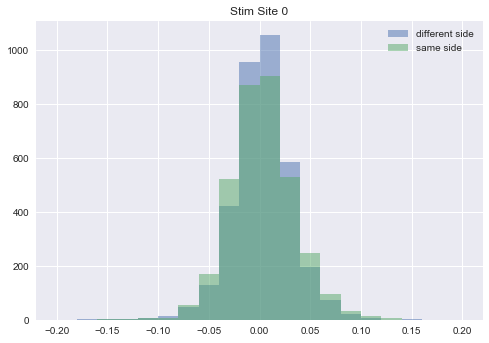

(335,)
train_rates (335, 55, 84)
stim_site (335,)
behavior_report (335,)
behavior_report_type (335,)
N, T, K:  41 13 84
(84,)
0.4642857142857143


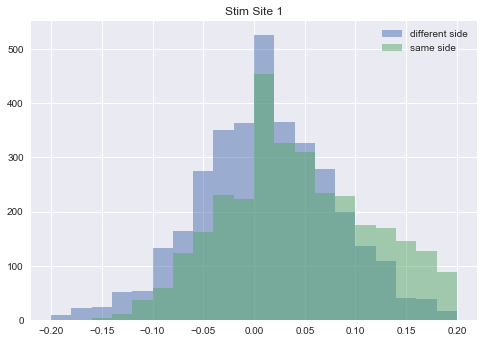

(335,)
train_rates (335, 55, 84)
stim_site (335,)
behavior_report (335,)
behavior_report_type (335,)
N, T, K:  49 13 84
(84,)
0.4642857142857143


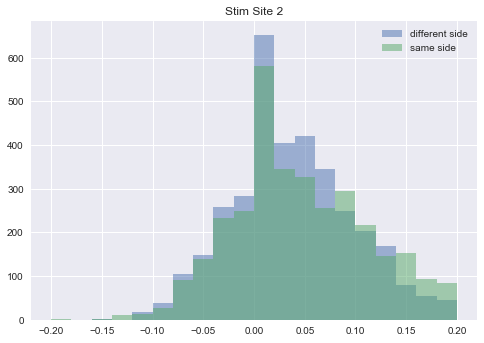

(335,)
train_rates (335, 55, 84)
stim_site (335,)
behavior_report (335,)
behavior_report_type (335,)
N, T, K:  42 13 84
(84,)
0.4642857142857143


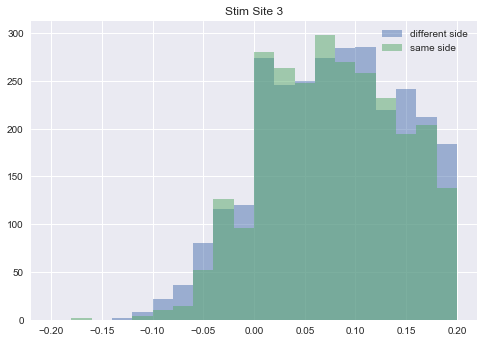

In [356]:
for stim_site in range(4):
    data = load_data(0, stim_site)
    train_rates = data.train_rates[:, 22:36, :]
    train_rates = differentiate(train_rates)
    N, T, K = train_rates.shape
    print('N, T, K: ', N, T, K)
    print(data.neuron_locations.shape)
    mat = np.zeros([K, K])
    side = np.zeros([K, K])
    for k1 in range(K):
        for k2 in range(k1, K):
            v1 = train_rates[:, :, k1].flatten()
            v2 = train_rates[:, :, k2].flatten()
            value = cos_diff(v1, v2)
    #         value, _ = pearsonr(v1, v2)
            location = data.neuron_locations[k1] == data.neuron_locations[k2]
    #         value = cos_diff(np.log(v1 + 1), np.log(v2 + 1))
            mat[k1, k2] = value
            mat[k2, k1] = value
            side[k1, k2] = location
            side[k2, k1] = location
    print(np.mean(data.neuron_locations))
    plt.figure()
    plot_range=[-0.2, 0.2]
    plt.hist(mat.flatten()[side.flatten() == 0], bins=20, label='different side', alpha=0.5, range=plot_range)
    plt.hist(mat.flatten()[side.flatten() == 1], bins=20, label='same side', alpha=0.5, range=plot_range)
    plt.title('Stim Site {}'.format(stim_site))
    plt.legend()
    plt.show()

(array([4.24687e+05, 0.00000e+00, 1.63269e+05, 0.00000e+00, 1.83059e+05,
        5.46320e+04, 8.12420e+04, 2.73400e+04, 3.32300e+03, 3.08000e+02]),
 array([0.        , 0.43307333, 0.86614667, 1.29922   , 1.73229334,
        2.16536667, 2.59844   , 3.03151334, 3.46458667, 3.89766001,
        4.33073334]),
 <a list of 10 Patch objects>)

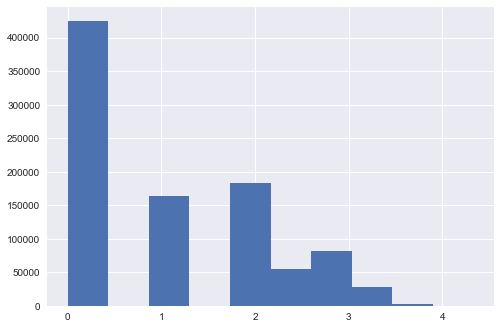

In [198]:
plt.hist(np.log(data.train_rates.flatten() + 1))

In [144]:
data.neuron_locations

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

(335,)
train_rates (335, 55, 84)
stim_site (335,)
behavior_report (335,)
behavior_report_type (335,)


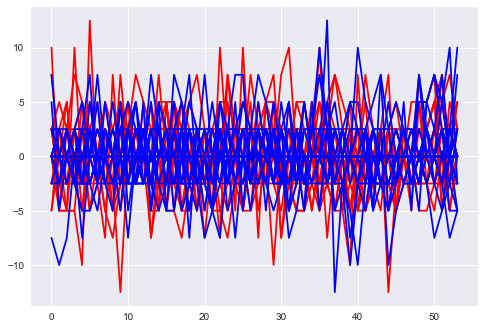

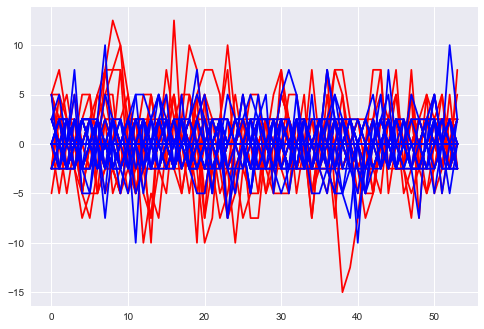

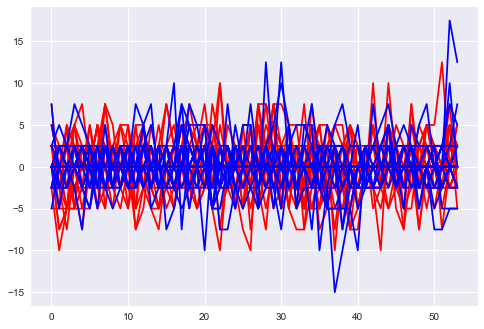

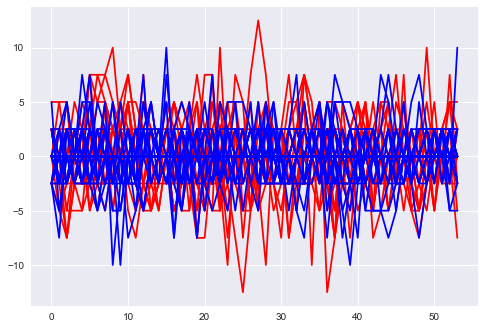

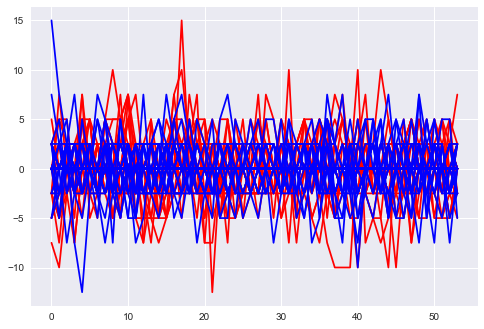

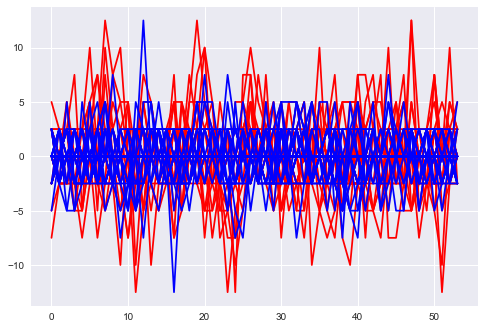

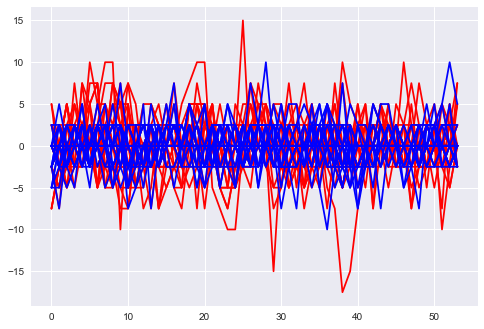

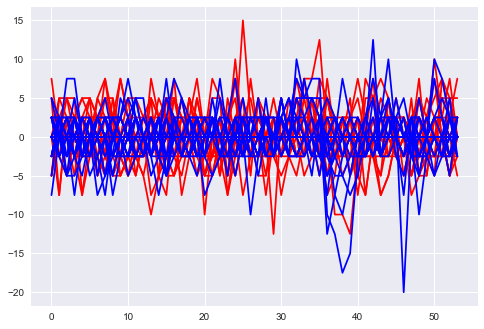

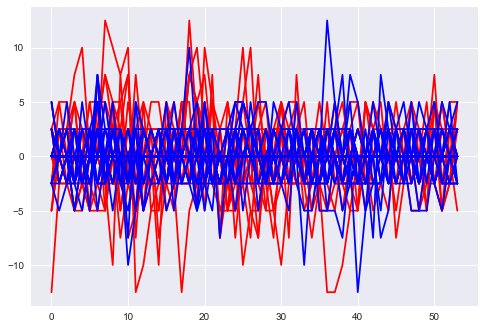

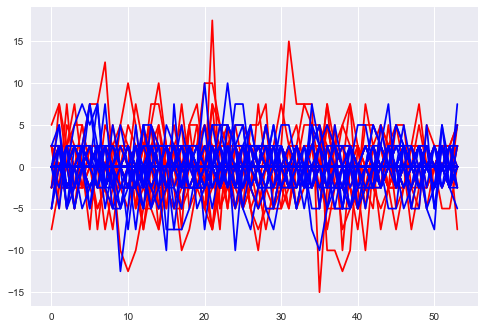

In [347]:
data = load_data(0, 0)
for index in range(10):
    plt.figure()
#     print(data.stim_site)
#     print(train_rates[index].shape)
    for i, arr in enumerate(data.train_rates[index].transpose()):
    #     plt.plot(arr)
        arr = arr[1:] - arr[:-1]
        if data.neuron_locations[i] == 0:
            plt.plot(arr, '-r')
        else:
            plt.plot(arr, '-b')
    plt.show()